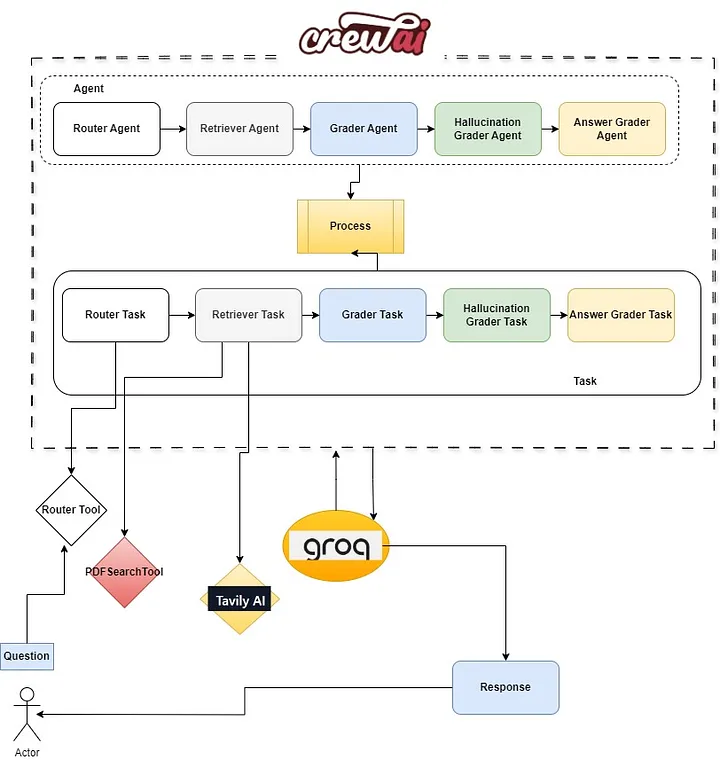

Here we will build a RAG Agent which will generate response for the question asked by retrieving relevant context if bthe question asked is about ESOPs otherwise the Agent will perform a web search to retrieve the required context and formulate a response that can be presented to the user.

**The RAG agent comprises of the following components:**

*  Router Agent: This agent decides whether to perform a RAG or external web search based on the context of the question asked.
*  Retriever Agent : This Agent retrieves context relevant to the question asked based on the mode suggested by the Router Agent.
*  Grader Agent: This Agent grades the context retrieved and check for the context relevancy with question asked.
*  Hallucination Grader Agent : This Agents grades the response from Retriever agent based on Usefulness and Facts
*  Answer Grader Agent: This Agent Generates the Final Response.
*  Router Task : Define task and expected output layout for Router Agent
*  Retriever Task: Define task and expected output layout for Retriever Agent
*  Grader Task : Define task and expected output layout for Grader Agent
*  Hallucination Grader Task: Define task and expected output layout for Hallucination Grader Agent
*  Answer Task : Define task and expected output layout for Answer grader Agent
*  Web Search Tool : Tool to perform external search
*  PDFSearchTool : CrewAI RAG tool designed for semantic searches within PDF content.
*  Llama3–8B as the Large Language Model

Code Implementation
Code implemented in Google Colab using CPU

Install Required Dependencies

In [ ]:
!pip install -qU crewai
!pip install crewai_tools
!pip install -qU langchain-groq
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.8/180.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.9/210.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.1 MB/s eta 0:0

In [ ]:
pip install langchain_huggingface

Generate and setup the GROQ_API_KEY

In [ ]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')


In [ ]:
# from langchain_groq import ChatGroq
# llm=ChatGroq(model="llama3-70b-8192")

In [114]:
llm = ChatOpenAI(
    openai_api_base="https://api.groq.com/openai/v1",
    openai_api_key="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",
    model_name="llama3-8b-8192",
    temperature=0.1,
    max_tokens=1000,
)

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_base="https://api.groq.com/openai/v1",
    openai_api_key=os.environ['GROQ_API_KEY'],
    model_name="llama-3.1-70b-versatile",
    temperature=0,
    max_tokens=1000,
)

In [ ]:
llm.invoke("How does exercise price determine for ESOP?")

AIMessage(content="The exercise price, also known as the strike price or option price, for an Employee Stock Option Plan (ESOP) is typically determined by the company's board of directors or compensation committee. The exercise price is usually set at the fair market value (FMV) of the company's stock on the date the option is granted.\n\nHere are some common methods used to determine the exercise price for ESOP:\n\n1. **Fair Market Value (FMV)**: The exercise price is set at the FMV of the company's stock on the date the option is granted. FMV is usually determined by the company's board of directors or an independent appraiser.\n2. **Market Price**: The exercise price is set at the market price of the company's stock on the date the option is granted. This method is often used for publicly traded companies.\n3. **Average Market Price**: The exercise price is set at the average market price of the company's stock over a specified period, such as 30 days or 60 days, prior to the grant 

Download input data for RAG(ESOP info)

In [ ]:
!wget "https://www.icsi.edu/media/webmodules/CSJ/January/17.pdf"

--2024-10-17 20:39:52--  https://www.icsi.edu/media/webmodules/CSJ/January/17.pdf
Resolving www.icsi.edu (www.icsi.edu)... 103.109.6.133
Connecting to www.icsi.edu (www.icsi.edu)|103.109.6.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 871378 (851K) [application/pdf]
Saving to: ‘17.pdf’

17.pdf              100%[===================>] 850.96K   756KB/s    in 1.1s    

2024-10-17 20:39:54 (756 KB/s) - ‘17.pdf’ saved [871378/871378]



Setup the LLM

In [ ]:
# import os
# from google.colab import userdata
# from langchain_groq import ChatGroq
# class GroqChatLLM(ChatGroq):
#     def __init__(self, temperature=0, model_name="llama3-70b-8192", api_key=None):
#         api_key = userdata.get("GROQ_API_KEY")

#         if not api_key:
#             raise ValueError("GROQ_API_KEY must be provided either as an argument or in the environment variables.")

#         # Directly call the superclass (ChatGroq) initialization
#         super().__init__(
#             temperature=temperature,
#             model_name=model_name,
#             api_key=api_key
#         )
######################################################################################################################
# from langchain_ollama import ChatOllama
# class OllamaLLM(ChatOllama):
#     def __init__(self, temperature=0, model_name="llama3.1"):
#         # Directly call the superclass (ChatOllama) initialization with the fixed base URL
#         super().__init__(
#             temperature=temperature,
#             model=model_name,
#         )

######################################################################################################################


In [ ]:
# llm=GroqChatLLM()

In [ ]:
llm.invoke("How does exercise price determine for ESOP?")

AIMessage(content="An Employee Stock Option Plan (ESOP) is a type of compensation plan that grants employees the right to purchase a certain number of shares of company stock at a predetermined price, known as the exercise price or strike price.\n\nThe exercise price of an ESOP is typically determined by the company's board of directors or a compensation committee, and it is usually based on the fair market value of the company's stock at the time the options are granted. The goal is to set an exercise price that is fair and reasonable, taking into account the company's current stock price, industry norms, and other relevant factors.\n\nHere are some common methods used to determine the exercise price of an ESOP:\n\n1. **Fair Market Value (FMV)**: The exercise price is set at the current fair market value of the company's stock, which is the price at which the stock is trading on a public exchange or the estimated value of the stock based on a valuation methodology.\n2. **Black-Scholes

***Create Tools***

Define the PDFSerachTool using custom model and embeddings

The PDFSearchTool is a RAG tool designed for semantic searches within PDF content. It allows for inputting a search query and a PDF document, leveraging advanced search techniques to find relevant content efficiently. This capability makes it especially useful for extracting specific information from large PDF files quickly.

In [ ]:
from crewai_tools import PDFSearchTool
rag_tool = PDFSearchTool(pdf='/content/17.pdf',
    config=dict(
        llm=dict(
            provider="groq", # or google, openai, anthropic, llama2, ...
            config=dict(
                model="llama3-8b-8192",
                # temperature=0.5,
                # top_p=1,
                # stream=true,
            ),
        ),
        embedder=dict(
            provider="huggingface", # or openai, ollama, ...
            config=dict(
                model="BAAI/bge-small-en-v1.5",
                #task_type="retrieval_document",
                # title="Embeddings",
            ),
        ),
    )
)

In [ ]:
rag_tool.run("How does exercise price determine for ESOP?")

Using Tool: Search a PDF's content


'Relevant Content:\noptions or shares. The employees are only able to obtain these shares once the ESOP vesting term has completed. Exercise period: It means the time period which starts after the completion of vesting period within which an employee can exercise his/her right to apply for shares against the vested options in pursuance of the scheme of ESOP approved by the shareholders in general meeting by way of Special Resolution. Exercise price: Means the price payable by an employee for exercising the options granted in pursuance of the scheme of ESOP. ARTICLE JANUARY 2024 | 107 CHARTERED SECRETARY\n\nESOP? A. Companies are free to decide the exercise price, which may be issued at a discount or premium but the exercise price determined by the Company shall not be less than the par value of the shares. Q. Does it mandatory for the Company to issue and allot only fresh shares under ESOP scheme? A. No, it is not mandatory for the company to issue and allot only fresh shares under ESO

Create Web Search Tool

In [ ]:
from crewai import Agent, Task, Crew, Process
from crewai_tools import SerperDevTool
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
# from langsmith import LangsmithClient
import os

from google.colab import userdata
#set your Api keys
os.environ["SERPER_API_KEY"]=userdata.get("SERPER_API_KEY")#
web_search_tool=SerperDevTool()

Create Custom Tool to facilitate the Router Agent

In [ ]:
from crewai_tools  import tool
@tool
def router_tool(question):
  """Router Function"""
  if 'ESOP' in question:
    return 'vectorstore'
  else:
    return 'web_search'

Define our agents
Agent Parameters used :
Role : Defines the agent’s function within the crew. It determines the kind of tasks the agent is best suited for.
Goal : The individual objective that the agent aims to achieve. It guides the agent’s decision-making process.
Backstory :Provides context to the agent’s role and goal, enriching the interaction and collaboration dynamics.
LLM (optional): Represents the language model that will run the agent. It dynamically fetches the model name from the OPENAI_MODEL_NAME environment variable, defaulting to "gpt-4" if not specified.
Verbose (optional): Setting this to True configures the internal logger to provide detailed execution logs, aiding in debugging and monitoring. Default is False.
Allow Delegation (optional): Agents can delegate tasks or questions to one another, ensuring that each task is handled by the most suitable agent. Default is True.

In [125]:
# LLM configuration
llm_config = {
    "provider": "groq",  # or "openai" if you're using OpenAI
    "config": {
            "model": "mixtral-8x7b-32768",  # Use a valid model name for the chosen provider

        "temperature": 0.7,
        "max_tokens": 500
    }
}

In [136]:
from litellm import completion
# Create a completion function using
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
def get_completion(prompt):
    response = completion(
        model="groq/llama-3.1-70b-versatile",  # Groq model
        messages=[{"role": "user", "content": prompt}],
         # Replace with your actual Groq API key
    )
    return response.choices[0].message.content

In [137]:
get_completion("100 usd into euro?")

'The exchange rate for USD to EUR can fluctuate constantly. As of my knowledge cutoff in 2023, the approximate exchange rate was 1 USD = 0.88 EUR. \n\nUsing this rate, we can calculate the conversion for 100 USD:\n\n100 USD * 0.88 EUR/USD ≈ 88 EUR\n\nPlease note that exchange rates can change frequently and might be different at the time of your query. For the most up-to-date conversion, I recommend checking a current exchange rate service or website.'

In [139]:
llm.invoke("How does exercise price determine for ESOP?")

AIMessage(content="In an Employee Stock Ownership Plan (ESOP), the exercise price, also known as the strike price, is the price at which employees can purchase company stock. The exercise price is typically determined by the ESOP's governing documents, such as the plan's trust agreement or the company's bylaws.\n\nHere are some common ways to determine the exercise price for an ESOP:\n\n1. **Fair Market Value (FMV)**: The exercise price is set equal to the FMV of the company's stock at the time the ESOP is established or at the time the employee is granted the option. FMV is typically determined by a third-party appraiser or a reputable stock exchange.\n2. **Book Value**: The exercise price is set equal to the company's book value, which is the company's net worth divided by the number of outstanding shares.\n3. **Discounted Cash Flow (DCF) Analysis**: The exercise price is determined by a DCF analysis, which estimates the present value of the company's future cash flows.\n4. **Market-

router Agent


In [138]:
Router_Agent = Agent(
  role='Router',
  goal='Route user question to a vectorstore or web search',
  backstory=(
    "You are an expert at routing a user question to a vectorstore or web search."
    "Use the vectorstore for questions on concepta related to Retrieval-Augmented Generation."
    "You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use web-search."
  ),
  verbose=True,
  allow_delegation=False,
  llm=get_completion,
)

ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable



Provider List: https://docs.litellm.ai/docs/providers



2. Retriever Agent

In [116]:
Retriever_Agent = Agent(
role="Retriever",
goal="Use the information retrieved from the vectorstore to answer the question",
backstory=(
    "You are an assistant for question-answering tasks."
    "Use the information present in the retrieved context to answer the question."
    "You have to provide a clear concise answer."
),
verbose=True,
allow_delegation=False,
llm=llm,
)

ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable



Provider List: https://docs.litellm.ai/docs/providers



3. Grader Agent



In [117]:
Grader_agent =  Agent(
  role='Answer Grader',
  goal='Filter out erroneous retrievals',
  backstory=(
    "You are a grader assessing relevance of a retrieved document to a user question."
    "If the document contains keywords related to the user question, grade it as relevant."
    "It does not need to be a stringent test.You have to make sure that the answer is relevant to the question."
  ),
  verbose=True,
  allow_delegation=False,
  llm=llm,
)

ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable



Provider List: https://docs.litellm.ai/docs/providers



4. Hallucination Grader Agent

In [118]:
hallucination_grader = Agent(
    role="Hallucination Grader",
    goal="Filter out hallucination",
    backstory=(
        "You are a hallucination grader assessing whether an answer is grounded in / supported by a set of facts."
        "Make sure you meticulously review the answer and check if the response provided is in alignmnet with the question asked"
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable



Provider List: https://docs.litellm.ai/docs/providers



5. Answer Grader Agent

In [119]:
answer_grader = Agent(
    role="Answer Grader",
    goal="Filter out hallucination from the answer.",
    backstory=(
        "You are a grader assessing whether an answer is useful to resolve a question."
        "Make sure you meticulously review the answer and check if it makes sense for the question asked"
        "If the answer is relevant generate a clear and concise response."
        "If the answer gnerated is not relevant then perform a websearch using 'web_search_tool'"
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable



Provider List: https://docs.litellm.ai/docs/providers



**Define Tasks for the agents**

**Task Parameters**

*   Description: A clear, concise statement of what the task entails.
*  Agent: The agent responsible for the task, assigned either directly or by the crew’s process.
*   Expected Output: A detailed description of what the task’s completion looks like.
*   Tools (optional): The functions or capabilities the agent can utilize to perform the task
*   Context (optional): Specifies tasks whose outputs are used as context for this task.



1.Router Task

In [120]:
router_task = Task(
    description=("Analyse the keywords in the question {question}"
    "Based on the keywords decide whether it is eligible for a vectorstore search or a web search."
    "Return a single word 'vectorstore' if it is eligible for vectorstore search."
    "Return a single word 'websearch' if it is eligible for web search."
    "Do not provide any other premable or explaination."
    ),
    expected_output=("Give a binary choice 'websearch' or 'vectorstore' based on the question"
    "Do not provide any other premable or explaination."),
    agent=Router_Agent,
    tools=[router_tool],
)

2. Retriever Task

In [ ]:
retriever_task = Task(
    description=("Based on the response from the router task extract information for the question {question} with the help of the respective tool."
    "Use the web_serach_tool to retrieve information from the web in case the router task output is 'websearch'."
    "Use the rag_tool to retrieve information from the vectorstore in case the router task output is 'vectorstore'."
    ),
    expected_output=("You should analyse the output of the 'router_task'"
    "If the response is 'websearch' then use the web_search_tool to retrieve information from the web."
    "If the response is 'vectorstore' then use the rag_tool to retrieve information from the vectorstore."
    "Return a claer and consise text as response."),
    agent=Retriever_Agent,
    context=[router_task],
   #tools=[retriever_tool],
)

3. Grader Task

In [ ]:
grader_task = Task(
    description=("Based on the response from the retriever task for the quetion {question} evaluate whether the retrieved content is relevant to the question."
    ),
    expected_output=("Binary score 'yes' or 'no' score to indicate whether the document is relevant to the question"
    "You must answer 'yes' if the response from the 'retriever_task' is in alignment with the question asked."
    "You must answer 'no' if the response from the 'retriever_task' is not in alignment with the question asked."
    "Do not provide any preamble or explanations except for 'yes' or 'no'."),
    agent=Grader_agent,
    context=[retriever_task],
)

4. Hallucination Grader Task

In [ ]:
hallucination_task = Task(
    description=("Based on the response from the grader task for the quetion {question} evaluate whether the answer is grounded in / supported by a set of facts."),
    expected_output=("Binary score 'yes' or 'no' score to indicate whether the answer is sync with the question asked"
    "Respond 'yes' if the answer is in useful and contains fact about the question asked."
    "Respond 'no' if the answer is not useful and does not contains fact about the question asked."
    "Do not provide any preamble or explanations except for 'yes' or 'no'."),
    agent=hallucination_grader,
    context=[grader_task],
)

5. Answer grader Task

In [ ]:
answer_task = Task(
    description=("Based on the response from the hallucination task for the quetion {question} evaluate whether the answer is useful to resolve the question."
    "If the answer is 'yes' return a clear and concise answer."
    "If the answer is 'no' then perform a 'websearch' and return the response"),
    expected_output=("Return a clear and concise response if the response from 'hallucination_task' is 'yes'."
    "Perform a web search using 'web_search_tool' and return ta clear and concise response only if the response from 'hallucination_task' is 'no'."
    "Otherwise respond as 'Sorry! unable to find a valid response'."),
    context=[hallucination_task],
    agent=answer_grader,
    #tools=[answer_grader_tool],
)

**Setup the Crew**

In CrewAI, processes orchestrate the execution of tasks by agents, akin to project management in human teams. These processes ensure tasks are distributed and executed efficiently, in alignment with a predefined strategy

**Process Implementations**

*  Sequential: Executes tasks sequentially, ensuring tasks are completed in an orderly progression.
*  Hierarchical: Organizes tasks in a managerial hierarchy, where tasks are delegated and executed based on a structured chain of command. A manager language model (manager_llm) must be specified in the crew to enable the hierarchical process, facilitating the creation and management of tasks by the manager.
*  Consensual Process (Planned): Aiming for collaborative decision-making among agents on task execution, this process type introduces a democratic approach to task management within CrewAI. It is planned for future development and is not currently implemented in the codebase.
By default the process is implemented as a Sequential process if no process is mentioned.

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent, Retriever_Agent, Grader_agent, hallucination_grader, answer_grader],
    tasks=[router_task, retriever_task, grader_task, hallucination_task, answer_task],
    verbose=True,

)

ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable
ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable
ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable
ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable
ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable



Provider List: https://docs.litellm.ai/docs/providers


Provider List: https://docs.litellm.ai/docs/providers


Provider List: https://docs.litellm.ai/docs/providers


Provider List: https://docs.litellm.ai/docs/providers


Provider List: https://docs.litellm.ai/docs/providers



Define the input

In [ ]:
inputs ={"question":"Does the ESOP supplement the salary of an employee?"}

***Kickoff the Crew***

In [ ]:
result = rag_crew.kickoff(inputs=inputs)

ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable
ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable
ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable
ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable
ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable
ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable
ERROR:root:LiteLLM call failed: litellm.BadRequestError: LLM Provider NOT provided. Pass in the LLM provider you are trying to call. You passed model=llama-3.1-70b-versatile
 Pass model as E.g. For 'Huggingface' inference endpoints pass in `completion(model='huggingface/starcoder',..)` Learn more: https://docs.litellm.ai/docs/providers
ERROR:root:Failed to get supported params: argument of type 'NoneType' is not iterable
ERROR:root:LiteLLM call failed: litellm.BadRequestErr


Provider List: https://docs.litellm.ai/docs/providers


Provider List: https://docs.litellm.ai/docs/providers


Provider List: https://docs.litellm.ai/docs/providers


Provider List: https://docs.litellm.ai/docs/providers


Provider List: https://docs.litellm.ai/docs/providers


Provider List: https://docs.litellm.ai/docs/providers

# Agent: Router
## Task: Analyse the keywords in the question Does the ESOP supplement the salary of an employee?Based on the keywords decide whether it is eligible for a vectorstore search or a web search.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.

Provider List: https://docs.litellm.ai/docs/providers

# Agent: Router
## Task: Analyse the keywords in the question Does the ESOP supplement the salary of an employee?Based on the keywords decide whether it is eligible for a vectorstore search or a web search.Ret

BadRequestError: litellm.BadRequestError: LLM Provider NOT provided. Pass in the LLM provider you are trying to call. You passed model=llama-3.1-70b-versatile
 Pass model as E.g. For 'Huggingface' inference endpoints pass in `completion(model='huggingface/starcoder',..)` Learn more: https://docs.litellm.ai/docs/providers

Let us test agent by agent functioning and completion
Test The Router Agent

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent],
    tasks=[router_task],
    verbose=True,

)
inputs ={"question":"Does the ESOP supplement the salary of an employee?"}
result = rag_crew.kickoff(inputs=inputs)

2. Test the Retriever Agent

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent,Retriever_Agent],
    tasks=[router_task,retriever_task],
    verbose=True,

)
inputs ={"question":"Does the ESOP supplement the salary of an employee?"}
result = rag_crew.kickoff(inputs

3. Test the Grader Agent

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent,Retriever_Agent,Grader_agent],
    tasks=[router_task,retriever_task,grader_task],
    verbose=True,

)
inputs ={"question":"Does the ESOP supplement the salary of an employee?"}
result = rag_crew.kickoff(inputs=inputs)

4. Test the Hallucination Grader Agent

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent,Retriever_Agent,Grader_agent,hallucination_grader],
    tasks=[router_task,retriever_task,grader_task,hallucination_task],
    verbose=True,

)
inputs ={"question":"Does the ESOP supplement the salary of an employee?"}
result = rag_crew.kickoff(inputs=inputs)

5. Test the Answer Grader Agent

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent,Retriever_Agent,Grader_agent,hallucination_grader,answer_grader],
    tasks=[router_task,retriever_task,grader_task,hallucination_task,answer_task],
    verbose=True,

)
inputs ={"question":"Does the ESOP supplement the salary of an employee?"}
result = rag_crew.kickoff(inputs=inputs)

Test the Agent with topic not related to ESOP

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent, Retriever_Agent, Grader_agent, hallucination_grader, answer_grader],
    tasks=[router_task, retriever_task, grader_task, hallucination_task, answer_task],
    verbose=True,

)
#
inputs = {"question":"What is Data Distributed Parallelism?"}
result = rag_crew.kickoff(inputs=inputs)

Testing the Agent on a new question related to ESOP

In [ ]:
rag_crew = Crew(
    agents=[Router_Agent, Retriever_Agent, Grader_agent, hallucination_grader, answer_grader],
    tasks=[router_task, retriever_task, grader_task, hallucination_task, answer_task],
    verbose=True,

)
#
inputs = {"question":"How does exercise price determine for ESOP?"}
result = rag_crew.kickoff(inputs=inputs)